In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
from scipy.stats import chisquare
import warnings
import pandas as pd

import matplotlib# lock matqplotlib for multithreading
matplotlib.use('Agg') 
from threading import Lock
matplotlib_lock = Lock()


STATPATH ='/home/bule/projects/Dice/rasperry_run/static'# r'C:\Users\buehl\repos\Dice\workspace\data\dicesides'

# helper function to place image on histogarmmplot
def place_image(ax, img_path, xy, zoom=1):
    # Load the image
    img = plt.imread(img_path)
    # Create an OffsetImage
    imagebox = OffsetImage(img, zoom=zoom)
    # Create an AnnotationBbox
    ab = AnnotationBbox(imagebox, xy, frameon=True, xybox=(10, -15), boxcoords="offset points", pad=0)
    # Add it to the axes
    ax.add_artist(ab)



# plot histogram
def plot_histogram(data_path, column_name):
    
    '''read data from csv file and plot histogram of the column_name with annotated dices on x-axis'''
    
    with matplotlib_lock:
        df = pd.read_csv(data_path)

        rolls=df[column_name].dropna().tolist()
        # Theoretical distribution for a fair dice (uniform distribution)
        fair_probs = [1/6] * 6  # Since each outcome (1-6) has an equal probability
        
        p_value=0
        if len(rolls) != 0:
            # Counting the frequency of each outcome for the unfair dice
            unfair_probs = [rolls.count(i) / len(rolls) for i in range(1, 7)]
            observed_frequencies = [rolls.count(i) for i in range(1, 7)]
            expected_frequencies = [len(rolls) / 6] * 6
            chi_squared_stat, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)
        
        # Create the plot
        fig, ax = plt.subplots()

        # Plotting the bar charts
        ax.bar(range(1, 7), fair_probs, alpha=1, color='#0165A8', label='Theoretisch', width=0.4)
        
        if len(rolls) != 0 and column_name == 'red':
            ax.bar([x + 0.4 for x in range(1, 7)], unfair_probs, alpha=0.8, color='red', label='Gewürfelt', width=0.4)
        elif len(rolls) != 0 and column_name == 'white':
            ax.bar([x + 0.4 for x in range(1, 7)], unfair_probs, alpha=0.8, edgecolor='black', color='white', label='Gewürfelt', width=0.4)

        # Remove numerical x-tick labels and place images instead
        ax.set_xticks(range(1, 7))
        ax.set_xticklabels([])  # Remove x-tick labels
        ax.tick_params(axis='both', which='both', length=0)  # Remove axis ticks

        for i in range(1, 7):
            place_image(ax, os.path.join(args.STATPATH, f'side{i}.jpg'), xy=(i, 0), zoom=0.04)
            
        plt.title(f'Häufigkeiten von Würfelergebnissen, Anzahl Würfe: {len(rolls)} p= {p_value:.3f}')
        plt.legend()
        #plt.xlabel('Würfel Augen', labelpad=30)
        plt.ylabel('Relative Häufigkeit')
                
        plt.show()
        # img = BytesIO()
        # plt.savefig(img, format='png')
        # img.seek(0)
        # plt.close()
        # return img

#rolls = random.choices(outcomes, weights, k=20)
#histplot(rolls,dicecolor='white')
df = pd.read_csv('results.csv')
histplot(df['white'].dropna().tolist(),dicecolor='white')
histplot(df['red'].dropna().tolist(),dicecolor='red')

In [26]:
df = pd.read_csv('results.csv')
df

,throw,white,red
0,1,NaN,5


In [28]:
print(df['red'].dropna().tolist())

[5]


In [29]:
lis=df['white'].dropna().tolist()+df['red'].dropna().tolist()
print(lis)

[5]


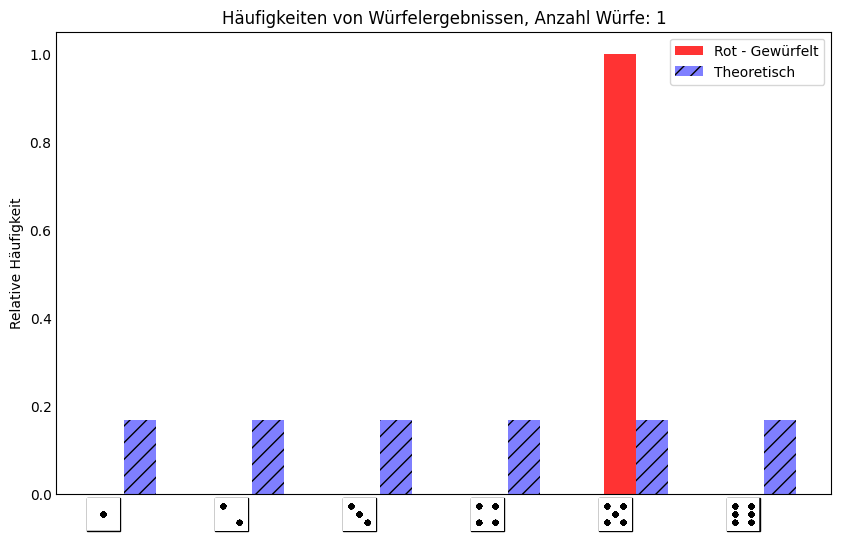

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import chisquare
from matplotlib.ticker import MaxNLocator

# Lock matplotlib for multithreading
#plt.switch_backend('Agg')
from threading import Lock
matplotlib_lock = Lock()

STATPATH = r'C:\Users\buehl\repos\Dice\rasperry_run\static'

def place_image(ax, img_path, xy, zoom=1):
    img = plt.imread(img_path)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=True, xybox=(20, -15), boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def plot_histogram(data_path, column_names=['white', 'red']):
    
    german_dict= {'white':'Weiss - Gewürfelt', 'red':'Rot - Gewürfelt'}
    with matplotlib_lock:
        df = pd.read_csv(data_path)
        fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size here
        
        # Set x-axis to integers only
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Plot each column's histogram side by side
        bar_width = 0.25
        for i, column_name in enumerate(column_names):
            rolls = df[column_name].dropna().tolist()
            if len(rolls) != 0:
                # Calculate observed frequencies and p-value
                observed_frequencies = [rolls.count(i) / len(rolls) for i in range(1, 7)]
                
                # Plot bar chart for observed frequencies
                ax.bar([x + i * bar_width for x in range(1, 7)], 
                       observed_frequencies, 
                       alpha=0.8, label=german_dict[column_name], width=bar_width,
                       edgecolor='black' if column_name == 'white' else None,
                       color='red' if column_name == 'red' else 'white')

        # Plot theoretical probabilities (shared between both columns)
        theoretical_probs = [1/6] * 6
        ax.bar([x + len(column_names) * bar_width for x in range(1, 7)], 
               theoretical_probs, 
               alpha=0.5, label=f'Theoretisch', width=bar_width,
               color='blue', hatch='//')

        # Remove numerical x-tick labels and place images instead
        ax.set_xticks([1 + i * bar_width + len(column_names) * bar_width / 2 for i in range(6)])
        ax.set_xticklabels([])  # Remove x-tick labels
        ax.tick_params(axis='both', which='both', length=0)  # Remove axis ticks

        for i in range(1, 7):
            place_image(ax, os.path.join(STATPATH, f'side{i}.jpg'), xy=(i, 0), zoom=0.04)

        plt.title(f' Anzahl Würfe - Rot: {len(df)}')
        plt.ylabel('Relative Häufigkeit')
        plt.legend()
        plt.show()

# Example usage:
plot_histogram('results.csv', ['white', 'red'])

In [2]:
def plot_histogram(data_path, column_name):
    
    # TODO error thrown when flaots in csv -> handle
    with matplotlib_lock:
        df = pd.read_csv(data_path)
    
        rolls=df[column_name].dropna().tolist()
        # Theoretical distribution for a fair dice (uniform distribution)
        fair_probs = [1/6] * 6  # Since each outcome (1-6) has an equal probability
        
        p_value=0
        if len(rolls) != 0:
            # Counting the frequency of each outcome for the unfair dice
            unfair_probs = [rolls.count(i) / len(rolls) for i in range(1, 7)]
            observed_frequencies = [rolls.count(i) for i in range(1, 7)]
            expected_frequencies = [len(rolls) / 6] * 6
            chi_squared_stat, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)
        
        # Create the plot
        fig, ax = plt.subplots()

        # Plotting the bar charts
        ax.bar(range(1, 7), fair_probs, alpha=1, color='#0165A8', label='Theoretisch', width=0.4)
        
        if len(rolls) != 0 and column_name == 'red':
            ax.bar([x + 0.4 for x in range(1, 7)], unfair_probs, alpha=0.8, color='red', label='Gewürfelt', width=0.4)
        elif len(rolls) != 0 and column_name == 'white':
            ax.bar([x + 0.4 for x in range(1, 7)], unfair_probs, alpha=0.8, edgecolor='black', color='white', label='Gewürfelt', width=0.4)

        # Remove numerical x-tick labels and place images instead
        ax.set_xticks(range(1, 7))
        ax.set_xticklabels([])  # Remove x-tick labels
        ax.tick_params(axis='both', which='both', length=0)  # Remove axis ticks

        for i in range(1, 7):
            place_image(ax, os.path.join(STATPATH, f'side{i}.jpg'), xy=(i, 0), zoom=0.04)
            
        plt.title(f'Häufigkeiten von Würfelergebnissen, Anzahl Würfe: {len(rolls)} p= {p_value:.3f}')
        plt.legend()
        plt.xlabel('Würfel Augen', labelpad=30)
        plt.ylabel('Relative Häufigkeit')
                

        img = BytesIO()
        plt.savefig(img, format='png')
        img.seek(0)
        plt.close()
        return img

## Recoridng mechanism for frameloop

In [3]:

def append_to_csv(filepath, new_df):
    existing_df = pd.read_csv(filepath)
    updated_df = pd.concat([existing_df, new_df], ignore_index=True)
    updated_df.to_csv(filepath, index=False)

def check_empty_dice_results(filepath):
    df = pd.read_csv(filepath)
    if df.empty:
        return True
    return False

def create_dataframe_fillNA(data:dict):
    ''' Create a DataFrame from a dictionary and fill missing values with NaN'''
    max_length = max(len(values) for values in data.values())
    for key, values in data.items():
        data[key] = values + [None] * (max_length - len(values))
    return pd.DataFrame(data)

def dummy_dice_pred():
    dice_dict = {"white": [], "red": []}
    
    for color in dice_dict:
        num_numbers = 1 #random.randint(0, 5)  # Randomly select the number of numbers to add
        numbers = [random.randint(1, 6) for _ in range(num_numbers)]  # Generate random numbers
        dice_dict[color] = numbers
    
    return dice_dict , True

def write_res(dice_prediction, filepath='result/results.csv'):
    dice_dict, dice_pass = dice_prediction
    if not dice_pass:
        dice_msg="Dice: Prediction failed, try again!"
    
    else:
        if check_empty_dice_results(filepath):
            throw_number=0
            print("First throw")
        throw_number += 1
        
        dice_dict_NA=create_dataframe_fillNA(dice_dict)
        dice_dict_NA['throw'] = [throw_number] * len(dice_dict['white'])
        
        append_to_csv(filepath, dice_dict_NA)
        
        dice_msg="Dice: "+str(dice_dict)
        
    return dice_msg 

In [4]:
# initial data for the csv
# gets cleared by user

results={"throw":[],"white":[],"red":[]}
df = pd.DataFrame(results)
df.to_csv('results.csv', index=False)

First throw
Dice: {'white': [3], 'red': [5]}
Dice: {'white': [3], 'red': [1]}
Dice: {'white': [2], 'red': [3]}
Dice: {'white': [3], 'red': [2]}
Dice: {'white': [3], 'red': [4]}
Dice: {'white': [4], 'red': [5]}
Dice: {'white': [1], 'red': [4]}
Dice: {'white': [5], 'red': [1]}
Dice: {'white': [5], 'red': [6]}
Dice: {'white': [1], 'red': [2]}


FileNotFoundError: [Errno 2] No such file or directory: '/home/bule/projects/Dice/rasperry_run/static\\side1.jpg'

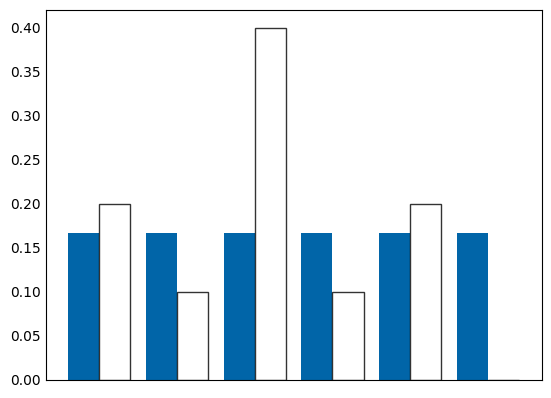

In [5]:

# if dice prediction is available, show it    
dice_prediction = True # assume state sets to capture

for _ in range(10):
    if dice_prediction:
        dice_dict, dice_pass = dummy_dice_pred()
        if not dice_pass:
            print("INVALID THROW, Please try again!")
            # TODO add to ouptu message
        else:
            if check_empty_dice_results(f'results.csv'):
                throw_number=0
                print("First throw")
            throw_number += 1
            
            dice_dict_NA=create_dataframe_fillNA(dice_dict)
            dice_dict_NA['throw'] = [throw_number] * len(dice_dict['white'])
            
            append_to_csv('results.csv', dice_dict_NA)
            warnings.simplefilter(action='ignore', category=FutureWarning)
            dice_msg="Dice: "+str(dice_dict)
            print(dice_msg)
        
df = pd.read_csv('results.csv')
histplot(df['white'].dropna().tolist(),dicecolor='white')
histplot(df['red'].dropna().tolist(),dicecolor='red')

In [ ]:
df = pd.read_csv('results.csv')
histplot(df['white'].dropna().tolist(),dicecolor='white')
histplot(df['red'].dropna().tolist(),dicecolor='red')

NameError: name 'histplot' is not defined

## with go 

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from scipy.stats import chisquare
import os
from PIL import Image
from io import BytesIO

def plot_histogram(df, column_name):
    
   
    
    rolls = df[column_name].dropna().tolist()
    observed_frequencies = [rolls.count(i) for i in range(1, 7)]
    expected_frequencies = [len(rolls) / 6] * 6
    
    p_value = 0
    if len(rolls) != 0:
        chi_squared_stat, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)
    
    # Create the plot
    fig = go.Figure()
    
    # Plotting the bar charts
    fig.add_trace(go.Bar(x=np.arange(1, 7), y=[1/6]*6, name='Theoretisch', marker_color='#0165A8'))
    
    if len(rolls) != 0 and column_name == 'red':
        fig.add_trace(go.Bar(x=np.arange(1, 7), y=observed_frequencies/np.sum(observed_frequencies), 
                             name='Gewürfelt', marker_color='red'))
    elif len(rolls) != 0 and column_name == 'white':
        fig.add_trace(go.Bar(x=np.arange(1, 7), y=observed_frequencies/np.sum(observed_frequencies), 
                             name='Gewürfelt', marker_color='white', marker_line_color='black'))
    
    # Update x-axis and y-axis labels
    fig.update_xaxes(title_text='Würfel Augen')
    fig.update_yaxes(title_text='Relative Häufigkeit')
    
    # Set title
    fig.update_layout(title=f'Häufigkeiten von Würfelergebnissen, Anzahl Würfe: {len(rolls)} p= {p_value:.3f}',
                      barmode='group', legend=dict(x=0.7, y=1))
    
    # Save the plot to an image
    img_bytes = fig.to_image(format="png")
    
    return BytesIO(img_bytes)

In [ ]:
df

,throw,white,red
0,1,2,3


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.stats import chisquare
from io import BytesIO

def plot_histogram(df, column_name):
    rolls = df[column_name].dropna()
    observed_frequencies = [rolls.tolist().count(i) for i in range(1, 7)]
    expected_frequencies = [len(rolls) / 6] * 6

    p_value = 0
    if len(rolls) != 0:
        chi_squared_stat, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)

    # Create the plot
    fig = go.Figure()

    # Plotting the bar charts
    fig.add_trace(go.Bar(x=np.arange(1, 7), y=[1/6]*6, name='Theoretisch', marker_color='#0165A8'))

    if len(rolls) != 0 and column_name == 'red':
        fig.add_trace(go.Bar(x=np.arange(1, 7), y=observed_frequencies/np.sum(observed_frequencies),
                             name='Gewürfelt', marker_color='red'))
    elif len(rolls) != 0 and column_name == 'white':
        fig.add_trace(go.Bar(x=np.arange(1, 7), y=observed_frequencies/np.sum(observed_frequencies),
                             name='Gewürfelt', marker_color='white', marker_line_color='black'))

    # Update x-axis and y-axis labels
    fig.update_xaxes(title_text='Würfel Augen')
    fig.update_yaxes(title_text='Relative Häufigkeit')

    # Set title
    fig.update_layout(title=f'Häufigkeiten von Würfelergebnissen, Anzahl Würfe: {len(rolls)} p= {p_value:.3f}',
                      barmode='group', legend=dict(x=0.7, y=1))

    
    fig.show()
    # # Save the plot to an image
    # img_bytes = fig.to_image(format="png")

    # return BytesIO(img_bytes)

# Load the DataFrame
df = pd.read_csv(r'C:\Users\buehl\repos\Dice\rasperry_run\results\results.csv')

# Plot histogram for 'white' and 'red' columns
plot_histogram(df, column_name='white')
plot_histogram(df, column_name='red')
